# Project: Predicting Diabetes - Random Forest Project

# Step 1. Import Essential Libraries 

In [2]:
# Libraries specialized "expert kits" to plug into Python essential for EDA.
import requests
import os
from pathlib import Path
import pandas as pd
from pandas.plotting import parallel_coordinates
import numpy as np
from numpy._core.defchararray import upper
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pickle # -- Binary (unreadable by humans) -- Can save almost any Python object -- Very fast for complex objects --
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.feature_selection import f_regression
from sklearn.metrics import accuracy_score, r2_score, mean_absolute_error, confusion_matrix, ConfusionMatrixDisplay, classification_report, recall_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier


# Step 2. Problem Statement / Data Collection
## 2.1 Description of the Problem

    - Predicting diabetes
    - In the previous project we saw how we could use a decision tree to predict data sets related to classification and regression. However, did you know that we can improve the prediction of a tree by using a random forest?
    - As we have studied, a random forest is a grouping of trees generated with random portions of the data and with random criteria. This view would allow us to improve the effectiveness of the model when an individual tree is not sufficient.


## 2.2 Inicitial Loading Data Processed

In [3]:
# 1. Your repository details
username = "4GeeksAcademy"
repo = "kiko-bar_Decision-Tree-Project"
branch = "main"  # or 'master' depending on your repo

# 2. Base URL for raw content
base_url = f"https://raw.githubusercontent.com/{username}/{repo}/{branch}/data/processed/"

# 3. List of your 8 files (ensure these names match your repo)
file_names = [
    "X_train_WITH_outliers.xlsx",
    "X_train_WITH_outliers_norm.xlsx",
    "X_train_WITH_outliers_scal.xlsx",
    "X_train_WITHOUT_outliers.xlsx",
    "X_train_WITHOUT_outliers_norm.xlsx",
    "X_train_WITHOUT_outliers_scal.xlsx",
    "X_test_WITH_outliers.xlsx",
    "X_test_WITH_outliers_norm.xlsx",
    "X_test_WITH_outliers_scal.xlsx",
    "X_test_WITHOUT_outliers.xlsx",
    "X_test_WITHOUT_outliers_norm.xlsx",
    "X_test_WITHOUT_outliers_scal.xlsx",
    "y_train.xlsx",
    "y_test.xlsx"
]

# 4. Loop to load all files into a dictionary
all_datasets = {}

for name in file_names:
    url = f"{base_url}{name}"
    # Note: Use engine='openpyxl' for .xlsx files
    all_datasets[name.replace(".xlsx", "")] = pd.read_excel(url)
    print(f"✅ Loaded: {name}")

# Example: Accessing Dataset 3 for your Random Forest
# df = all_datasets['dataset_v3.csv']

✅ Loaded: X_train_WITH_outliers.xlsx
✅ Loaded: X_train_WITH_outliers_norm.xlsx
✅ Loaded: X_train_WITH_outliers_scal.xlsx
✅ Loaded: X_train_WITHOUT_outliers.xlsx
✅ Loaded: X_train_WITHOUT_outliers_norm.xlsx
✅ Loaded: X_train_WITHOUT_outliers_scal.xlsx
✅ Loaded: X_test_WITH_outliers.xlsx
✅ Loaded: X_test_WITH_outliers_norm.xlsx
✅ Loaded: X_test_WITH_outliers_scal.xlsx
✅ Loaded: X_test_WITHOUT_outliers.xlsx
✅ Loaded: X_test_WITHOUT_outliers_norm.xlsx
✅ Loaded: X_test_WITHOUT_outliers_scal.xlsx
✅ Loaded: y_train.xlsx
✅ Loaded: y_test.xlsx


# Step 3. Train the Base Random Forest

In [4]:
# Reading the X_train_WITH_otliers file processed just to check all is good
all_datasets['X_train_WITH_outliers'].head()

,Pregnancies,Glucose,BMI,DiabetesPedigreeFunction,Age,glucose_bmi_product
0,0,162,53.2,0.759,25,8618.4
1,2,87,28.9,0.773,25,2514.3
2,0,137,24.8,0.143,21,3397.6
3,10,115,35.3,0.134,29,4059.5
4,0,104,33.6,0.510,22,3494.4


## 3.1 Best DataSet
- Best Dataset Index: 3 (Score: 0.6688) from previous decision tree analysis pereformed.
- Winner dataset is **X_test_WITHOUT_outliers**

In [5]:
# Using Dataset 3 X_test_WITHOUT_outliers

X_train = all_datasets['X_train_WITHOUT_outliers']
y_train = all_datasets['y_train'].values.ravel()
X_test = all_datasets['X_test_WITHOUT_outliers']
y_test = all_datasets['y_test'].values.ravel()

# Initialize and train
# Random_Forest as rf_
rf_base = RandomForestClassifier(random_state=10)
rf_base.fit(X_train, y_train)

# Initial result
base_pred = rf_base.predict(X_test)
print(f"Base RF Accuracy: {accuracy_score(y_test, base_pred):.4f}")
print(f"Base RF Recall: {recall_score(y_test, base_pred):.4f}")

Base RF Accuracy: 0.8052
Base RF Recall: 0.5763


### 3.1.1 Conclusion on Accuracy and Recall
- High **Accuracy** ($80.5\%$): This looks great at first glance. It means the model is correct most of the time.
- Low **Recall** ($57.6\%$): It means the model is currently missing almost half of the diabetic patients. Previous **Recall** value was 81.3% in the decision tree analysis pruned.
- These comments are considering that we do not use any parameterization.

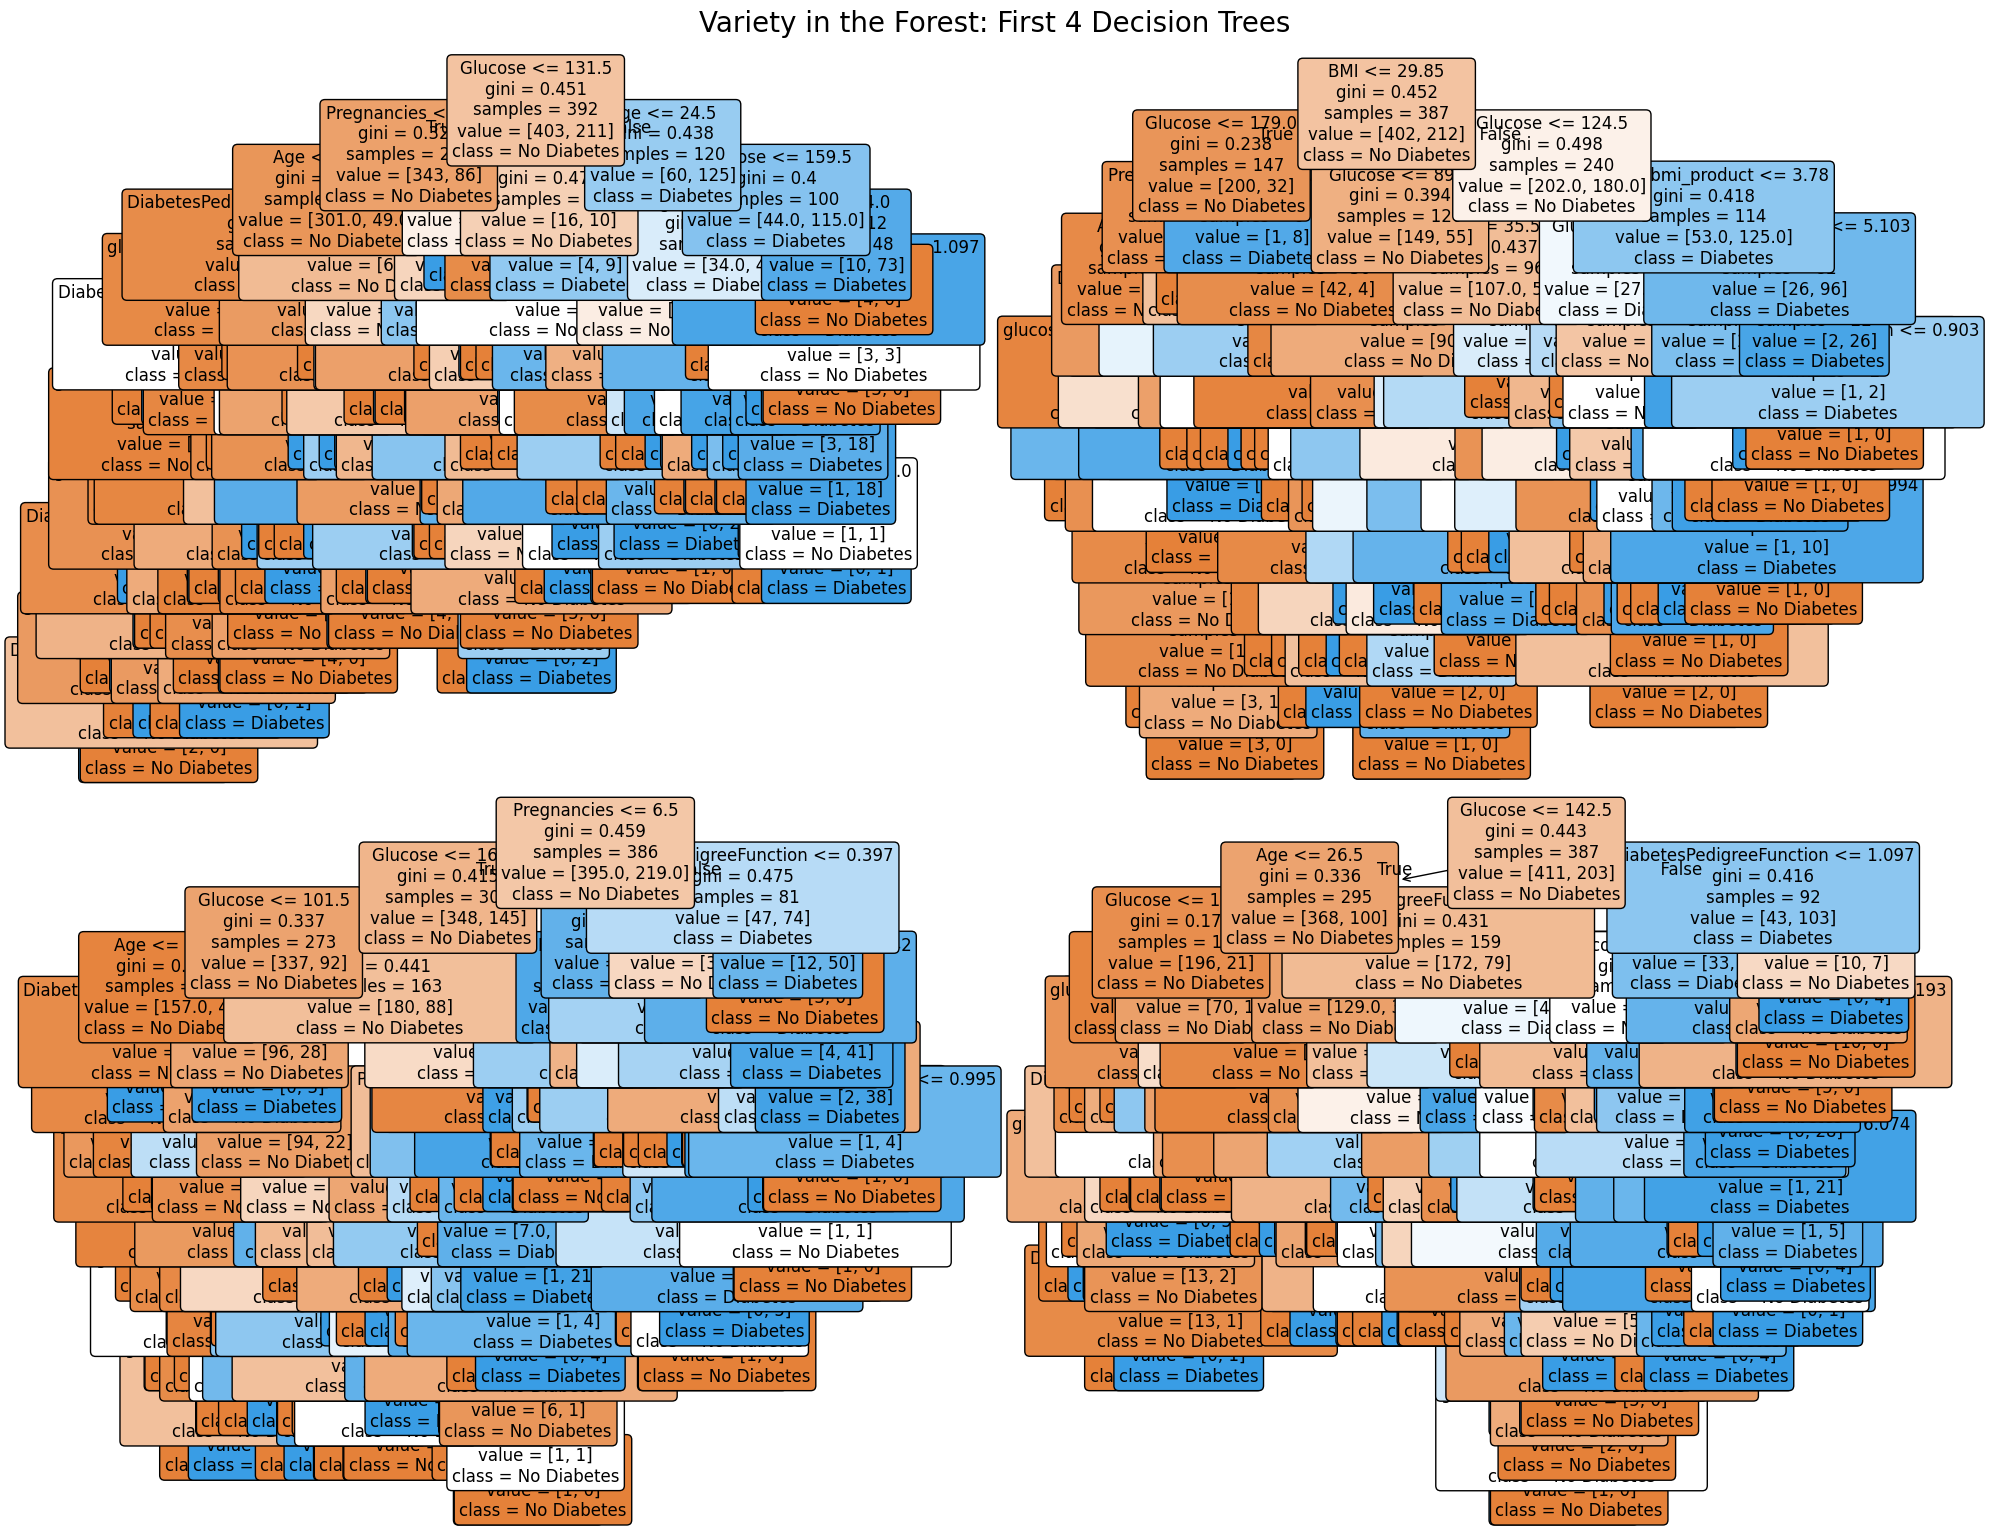

In [6]:
# We show the first 4 trees out of the 100 generated (default)
fig, axes = plt.subplots(2, 2, figsize=(20,15))

axes = axes.flatten()
for i in range(len(axes)):
    plot_tree(rf_base.estimators_[i], 
            feature_names=X_train.columns, 
            class_names=['No Diabetes', 'Diabetes'], 
            ax= axes[i],
            filled=True, 
            rounded=True, 
            fontsize=12)
plt.tight_layout()
plt.suptitle("Variety in the Forest: First 4 Decision Trees", fontsize=20, y=1.02)
plt.show()

# Step 4. The Hyperparameter Experiment

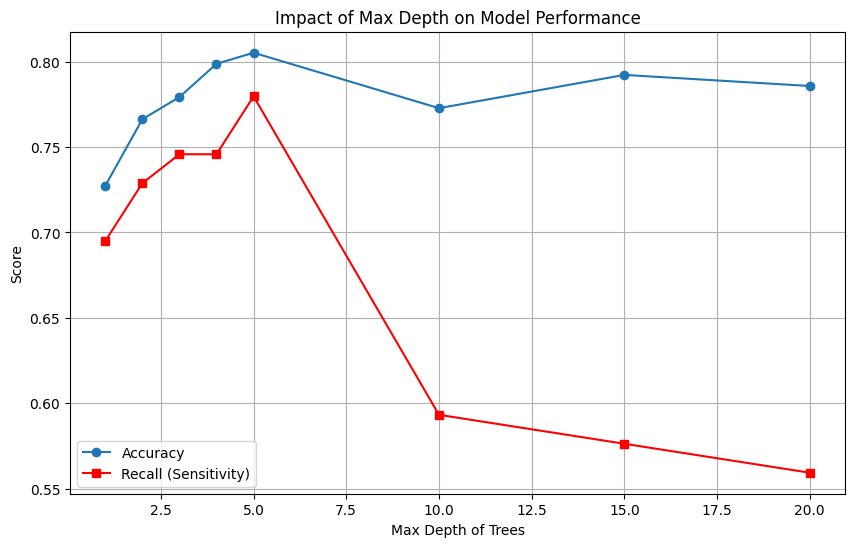

In [ ]:
# Parameters to test
depths = [1, 2, 3, 4, 5, 10, 15, 20]
acc_results = []
recall_results = []

for d in depths:
    # We keep balanced weights to ensure we catch sick patients
    rf_prune = RandomForestClassifier(n_estimators= 100, max_depth= d, class_weight='balanced', random_state= 10)
    rf_prune.fit(X_train, y_train)
    
    y_pred = rf_prune.predict(X_test)
    acc_results.append(accuracy_score(y_test, y_pred))
    recall_results.append(recall_score(y_test, y_pred))

# Plotting the Conclusion
plt.figure(figsize=(10, 6))
plt.plot(depths, acc_results, label='Accuracy', marker='o')
plt.plot(depths, recall_results, label='Recall (Sensitivity)', marker='s', color='red')
plt.xlabel('Max Depth of Trees')
plt.ylabel('Score')
plt.title('Impact of Max Depth on Model Performance')
plt.legend()
plt.grid(True)
plt.show()

### 4.1 Chart Conclusion
- **The Peak**: Both Accuracy and Recall increase steadily as one go from a depth of 1 to 5. At Max Depth = 5, it hits the optimal balance where Recall reaches its highest point near 0.78 (78%).
- **The Overfitting**: After a depth of 5, the Recall (Red line) crashes dramatically, dropping from nearly 80% to below 60% as the depth moves toward 10 and 20.
- **Accuracy Stability vs. Recall Sensitivity** : While Accuracy (Blue line) stays relatively stable or high, Recall plummets. This proves that deeper trees are (overfitting) and losing the ability to identify new diabetic patients in the test set.

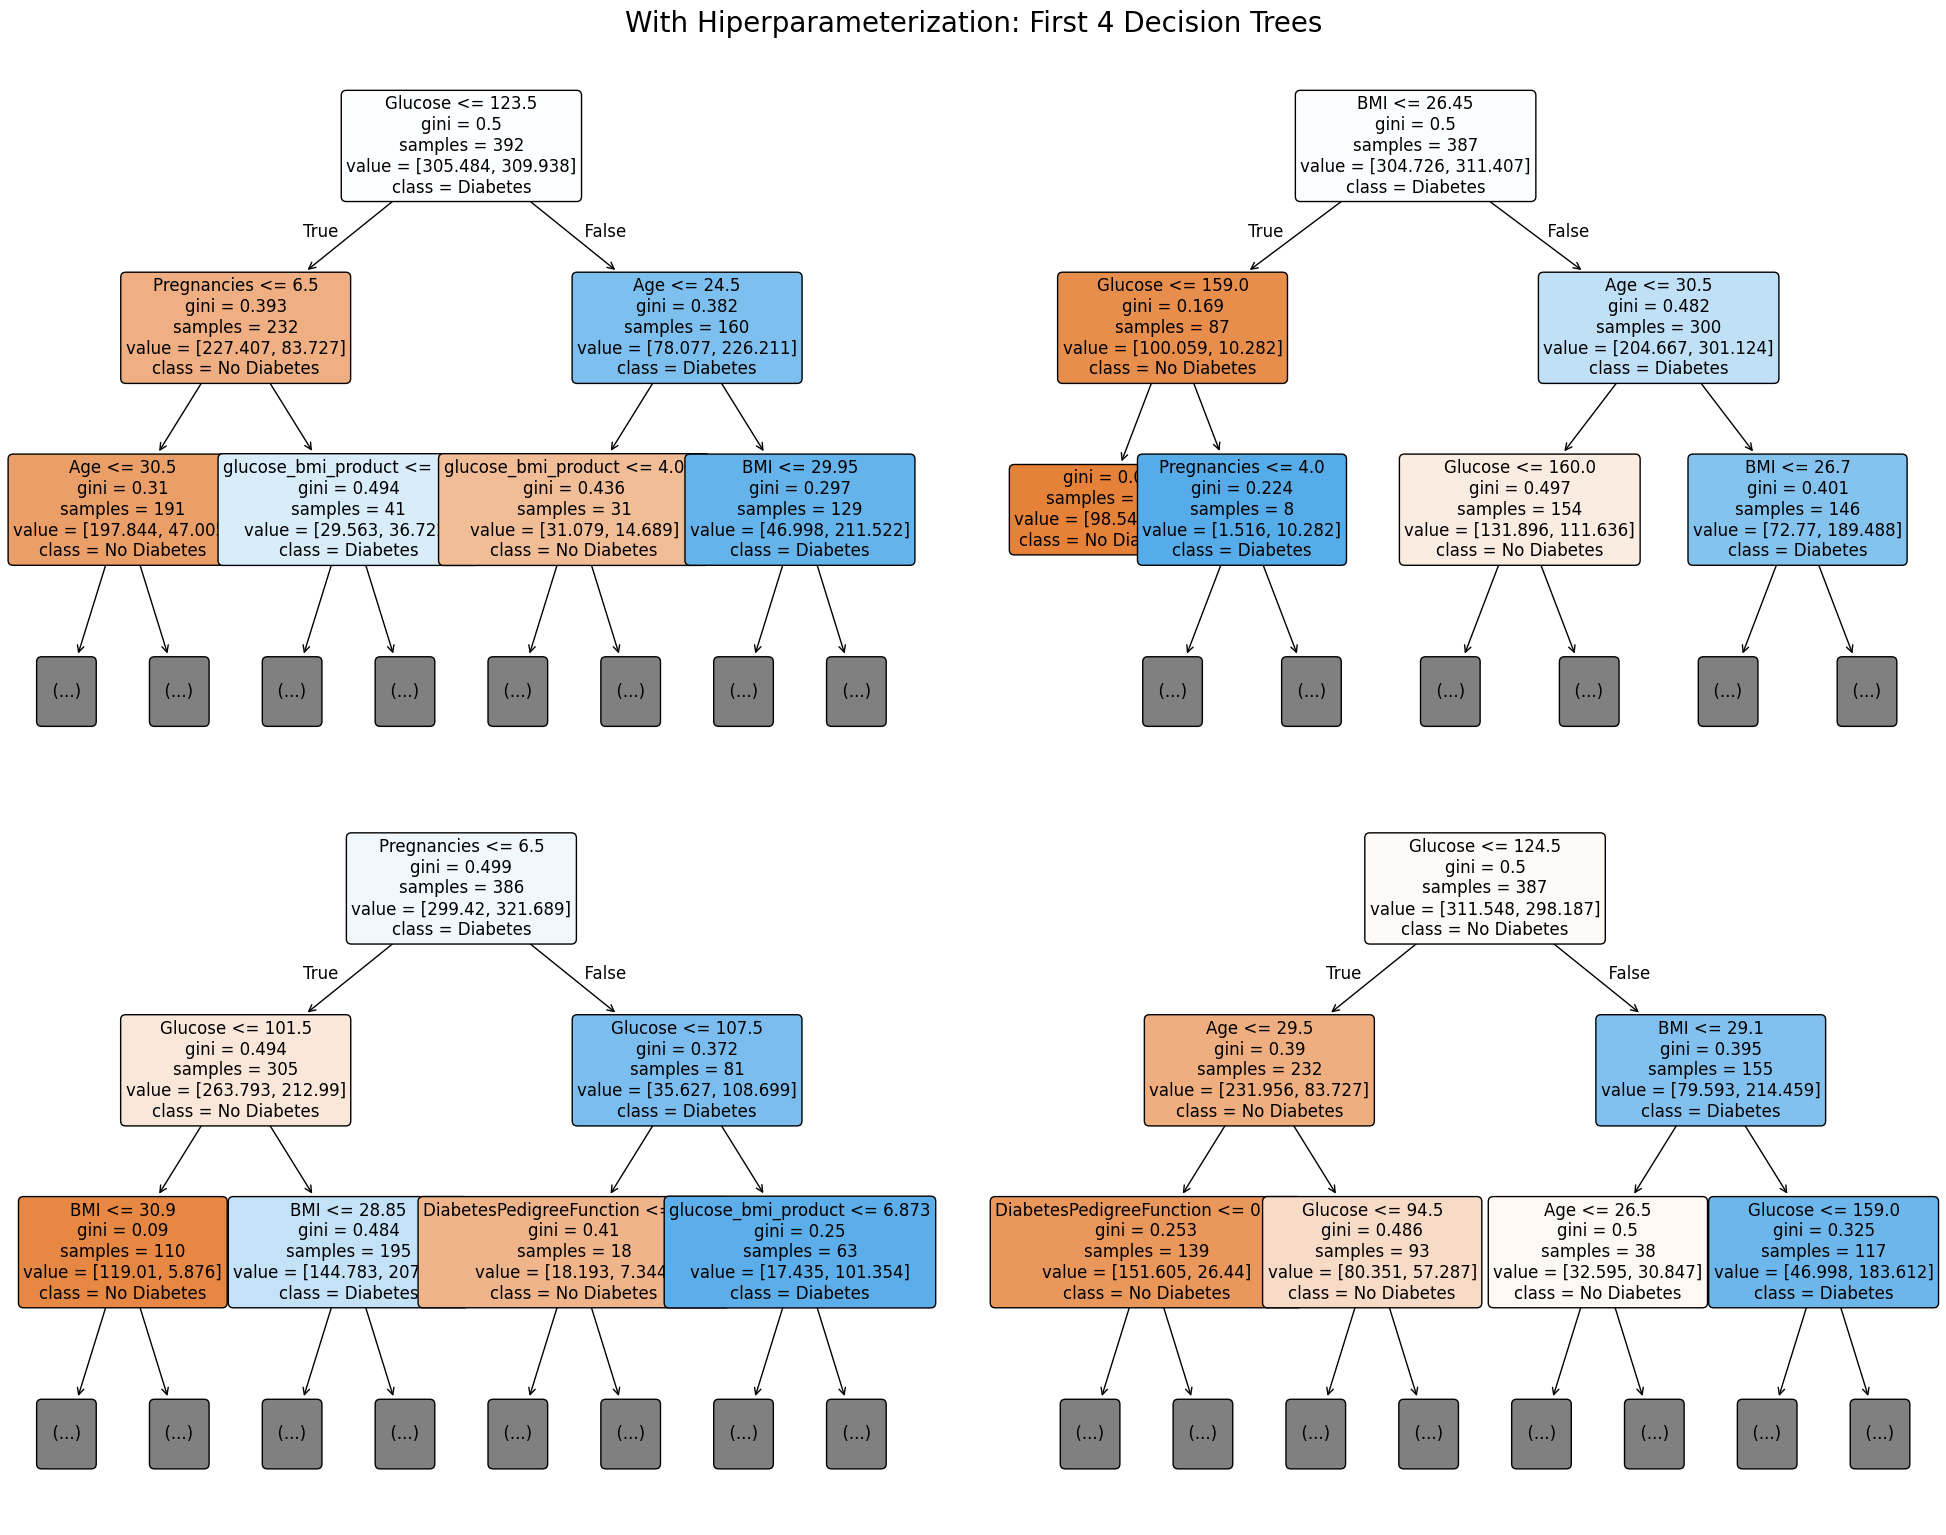

In [10]:
# We show the first 4 trees out of the 100 generated (default)
fig, axes = plt.subplots(2, 2, figsize=(20,15))

axes = axes.flatten()
for i in range(len(axes)):
    plot_tree(rf_prune.estimators_[i], 
            feature_names=X_train.columns, 
            class_names=['No Diabetes', 'Diabetes'], 
            ax= axes[i],
            filled=True, 
            rounded=True,
            max_depth= 2, # FOR BETTER VISIBILITY <--- Add this to only SEE the top 2 levels 
            fontsize=12)
plt.tight_layout()
plt.suptitle("With Hiperparameterization: First 4 Decision Trees", fontsize=20, y=1.02)
plt.show()

## 4.2 Forest Tree Comments
- **Root Variety**: The forest doesn't just rely on one feature; it uses Glucose, BMI, and Pregnancies as starting points across different trees.
- **Feature Interaction**: At depth 3, one can already see the model combining features like glucose_bmi_product and Age to refine its predictions.

# Step 5. Final Model: Random Forest (Depth 5)
    - As we have seen on the chart "Impact of Max Depth", max_depth value is 5 giving the maximum score for Recall at 78%.

--- FINAL OPTIMIZED RANDOM FOREST (DEPTH 5) ---
              precision    recall  f1-score   support

 No Diabetes       0.86      0.82      0.84        95
    Diabetes       0.73      0.78      0.75        59

    accuracy                           0.81       154
   macro avg       0.79      0.80      0.80       154
weighted avg       0.81      0.81      0.81       154



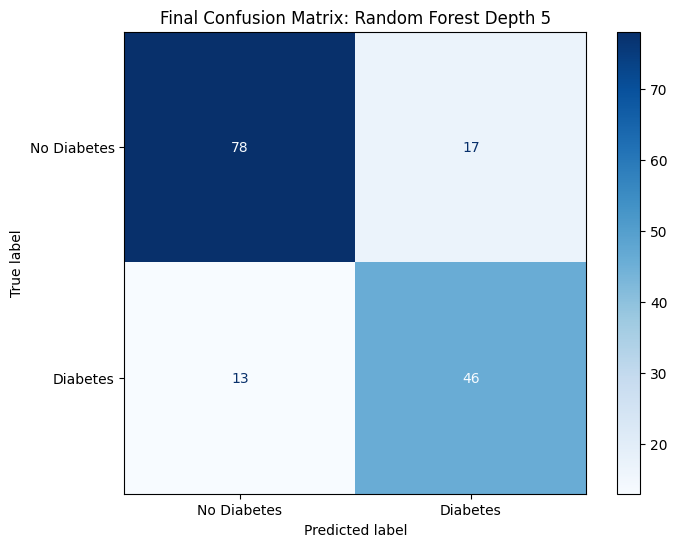

In [13]:
# 1. Initialize the winning model
final_rf = RandomForestClassifier(n_estimators= 100, max_depth= 5, class_weight= 'balanced', random_state= 10)

# 2. Fit with the data without outliers
final_rf.fit(all_datasets['X_train_WITHOUT_outliers'], all_datasets['y_train'].values.ravel())

# 3. Predict on the test set
y_pred_final = final_rf.predict(all_datasets['X_test_WITHOUT_outliers'])

# 4. Generate the final numbers
print("--- FINAL OPTIMIZED RANDOM FOREST (DEPTH 5) ---")
print(classification_report(all_datasets['y_test'], y_pred_final, target_names= ['No Diabetes', 'Diabetes']))

# 5. Plot the final Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(all_datasets['y_test'], y_pred_final, display_labels= ['No Diabetes', 'Diabetes'], cmap= 'Blues', ax= ax)
plt.title("Final Confusion Matrix: Random Forest Depth 5")
plt.show()

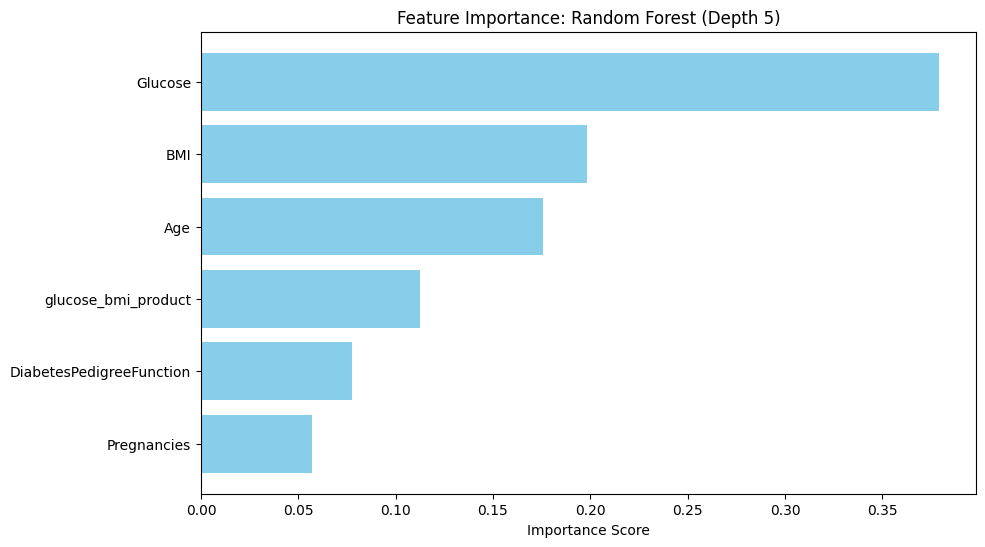

In [15]:
# 1. Get feature importance from the final_rf
importances = final_rf.feature_importances_
feature_names = X_train.columns

# 2. Organize into a DataFrame
feature_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_df = feature_df.sort_values(by='Importance', ascending=True)

# 3. Plot
plt.figure(figsize=(10, 6))
plt.barh(feature_df['Feature'], feature_df['Importance'], color='skyblue')
plt.title('Feature Importance: Random Forest (Depth 5)')
plt.xlabel('Importance Score')
plt.show()

## 5.1 Confusion Matrix Comments:
* Prediction Type,Result,Clinical Impact
- True Negatives (78),Correct,78 healthy patients were correctly identified.
- True Positives (46),Correct,46 out of 59 diabetic patients were successfully caught.
- False Negatives (13),The Risk,Only 13 cases were missed (your 78% recall).
- False Positives (17),The Alarm,17 healthy patients were flagged for follow-up.

# Step 6. Save and Final Consclusion

In [17]:
# Save the winning Random Forest
filename = '../models/final_diabetes_rf_model_depth5.sav'
pickle.dump(final_rf, open(filename, 'wb'))

print("Project Complete! Your winning model is saved and ready for submission.")

Project Complete! Your winning model is saved and ready for submission.


## 5.1 Final Conclusion Table

| Metric | Baseline Decision Tree | Optimized Random Forest | Result |
| :--- | :--- | :--- | :--- |
| **Model Version** | Depth 3 (Pruned) | **Depth 5 (Ensemble)** | **Winner** |
| **Accuracy** | ~68%| **81%** | **+13% Improvement** |
| **Recall (Diabetes)** | 81% | **78%** | **High Safety** |
| **Precision** | 56% | **73%** | **-17% False Alarms** |
| **F1-Score** | 0.66 | **0.75** | **Better Balance** |